# Brazilian E-commerce Customer Segmentation with Olist Dataset

## 0. 环境与数据 / Environment and Data

### 0.1 说明 / Description

本 Notebook 在 Kaggle 平台运行。

This notebook runs on the Kaggle platform.

Notebook 链接：[https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-customer-segmentation](https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-customer-segmentation)

Notebook Link: [https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-customer-segmentation](https://www.kaggle.com/code/yiquanxiao/brazilian-e-commerce-customer-segmentation)

### 0.2 依赖 / Dependencies

如需 LightGBM，可在 Kaggle 中执行：

If LightGBM is needed, run in Kaggle:

In [1]:
!pip install -U lightgbm

In [2]:
import pandas as pd  # 数据处理 / data manipulation
import numpy as np   # 数值计算 / numerical computing
import matplotlib.pyplot as plt  # 可视化 / visualization
import seaborn as sns  # 可视化 / visualization
from sklearn.preprocessing import StandardScaler  # 特征缩放 / feature scaling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import shap

## 1. 数据加载与整理 / Data Loading and Preparation

### 1.1 读取核心四张表：orders, order\_items, customers, payments 
Read the four core tables: orders, order\_items, customers, payments

In [3]:
# 从 Kaggle 平台加载所需数据集 / Load necessary datasets from Kaggle input
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')  # 客户信息 / customer data
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')      # 订单信息 / order data
order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')  # 订单商品明细 / order items detail
payments = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')  # 支付信息 / payment data

# 查看加载情况 / Quick check of loaded data shapes
print(f"customers: {customers.shape}")
print(f"orders: {orders.shape}")
print(f"order_items: {order_items.shape}")
print(f"payments: {payments.shape}")

customers: (99441, 5)
orders: (99441, 8)
order_items: (112650, 7)
payments: (103886, 5)


In [4]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


### 1.2 合并为“订单-用户”明细 / Merge into order-user level detail

In [8]:
# 仅保留关键字段以减少数据量 / Select only key fields to reduce size
orders = orders[['order_id', 'customer_id', 'order_purchase_timestamp']]
order_items = order_items[['order_id', 'product_id', 'price', 'freight_value']]
payments = payments[['order_id', 'payment_value', 'payment_type']]
customers = customers[['customer_id', 'customer_unique_id', 'customer_state']]

# 合并订单与商品明细 / Merge orders and order items
df = orders.merge(order_items, on='order_id', how='left')
# 合并客户信息 / Merge customer info
df = df.merge(customers, on='customer_id', how='left')
# 合并支付明细 / Merge payment info
df = df.merge(payments, on='order_id', how='left')

# 检查合并结果 / Check the merged dataframe
print(f"合并后数据维度: {df.shape}")
df.head()

合并后数据维度: (118434, 10)


,order_id,customer_id,order_purchase_timestamp,product_id,price,freight_value,customer_unique_id,customer_state,payment_value,payment_type
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,SP,18.12,credit_card
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,SP,2.00,voucher
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,SP,18.59,voucher
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,af07308b275d755c9edb36a90c618231,BA,141.46,boleto
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,159.90,19.22,3a653a41f6f9fc3d2a113cf8398680e8,GO,179.12,credit_card


### 1.3 确定基准日期（数据集中最新交易日） / Determine reference date (latest transaction date)

In [9]:
# 转换为 datetime / Convert column to datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
# 计算基准日期 / Compute reference date
reference_date = df['order_purchase_timestamp'].max()
print(f"基准日期: {reference_date}")  # Reference date

基准日期: 2018-10-17 17:30:18


## 2. RFM 特征工程 / RFM Feature Engineering

### 2.1 以 `customer_unique_id` 为粒度计算
Calculate based on the `customer_unique_id` granularity:

* **R** = 基准日 − 最近购买日 (天)

  R (Recency)** = Reference date − Most recent purchase date (in days)
  
* **F** = 订单数

  F (Frequency)** = Number of orders
  
* **M** = 累计付款金额

  M (Monetary)** = Total payment amount

In [10]:
# 1) 每单总付款 / Total payment per order
order_pay = payments.groupby('order_id')['payment_value'] \
                    .sum() \
                    .reset_index(name='order_total_value')

# 2) 将总付款与订单表合并，获得 customer_id 和 下单时间 / Merge with orders to get customer_id and purchase timestamp
orders_pay = orders.merge(order_pay, on='order_id', how='left')

# 3) 引入 customer_unique_id / Bring in unique customer identifier
orders_pay = orders_pay.merge(
    customers[['customer_id','customer_unique_id']],
    on='customer_id',
    how='left'
)

# 4) 转为 datetime 格式 / Convert to datetime
orders_pay['order_purchase_timestamp'] = pd.to_datetime(orders_pay['order_purchase_timestamp'])

# 5) 计算 R, F, M / Calculate Recency, Frequency, Monetary
rfm = orders_pay.groupby('customer_unique_id').agg(
    R = ('order_purchase_timestamp', lambda x: (reference_date - x.max()).days),  # 近期度 / Recency
    F = ('order_id', 'nunique'),  # 频次 / Frequency
    M = ('order_total_value', 'sum')  # 金额 / Monetary
).reset_index()

### 2.2 同时保留原值与 z-score（供后续聚类） / Keep raw values and z-scores for clustering

In [11]:
# 原始 RFM 值 / Raw RFM
rfm_raw = rfm[['customer_unique_id','R','F','M']].copy()

# 计算 z-score / Compute z-scores
scaler = StandardScaler()
rfm[['R_z','F_z','M_z']] = scaler.fit_transform(rfm[['R','F','M']])
rfm.head()

,customer_unique_id,R,F,M,R_z,F_z,M_z
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,-0.832621,-0.162368,-0.106697
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,-0.813067,-0.162368,-0.602360
2,0000f46a3911fa3c0805444483337064,585,1,86.22,1.937662,-0.162368,-0.347291
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,0.529706,-0.162368,-0.531366
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89,0.314602,-0.162368,0.130916


## 3. RFM 实现用户分群（可解释性） / RFM for Customer Segmentation (Interpretability)

### 3.1 以 R/F/M 的中位数做高/低二分 / Binary segmentation based on median

In [12]:
# 计算 R, F, M 的中位数 / Compute median of R, F, M
r_med = rfm['R'].median()
f_med = rfm['F'].median()
m_med = rfm['M'].median()

# 生成二元变量 / Create binary flags:
# R_seg = 1 表示最近购买（R <= median）；F_seg, M_seg = 1 表示高频/高金额（> median）
rfm['R_seg'] = (rfm['R'] <= r_med).astype(int)
rfm['F_seg'] = (rfm['F'] >  f_med).astype(int)
rfm['M_seg'] = (rfm['M'] >  m_med).astype(int)

### 3.2 生成 $2^3 = 8$ 个组合并映射成业务标签 / Generate 8 combinations and map to business labels

In [13]:
# 合并三位二进制为代码 / Combine bits into a 3-digit code
rfm['RFM_segment'] = (
    rfm['R_seg'].astype(str) +
    rfm['F_seg'].astype(str) +
    rfm['M_seg'].astype(str)
)

# 定义业务标签映射 / Define mapping to business labels
label_map = {
    '000': '一般挽留客户',
    '001': '重要挽留客户',
    '010': '一般保持客户',
    '011': '重要保持客户',
    '100': '一般发展客户',
    '101': '重要发展客户',
    '110': '一般价值客户',
    '111': '重要价值客户'
}


# 应用映射 / Map codes to labels
rfm['RFM_label'] = rfm['RFM_segment'].map(label_map)
rfm.head()

,customer_unique_id,R,F,M,R_z,F_z,M_z,R_seg,F_seg,M_seg,RFM_segment,RFM_label
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,-0.832621,-0.162368,-0.106697,1,0,1,101,重要发展客户
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,-0.813067,-0.162368,-0.602360,1,0,0,100,一般发展客户
2,0000f46a3911fa3c0805444483337064,585,1,86.22,1.937662,-0.162368,-0.347291,0,0,0,000,一般挽留客户
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,0.529706,-0.162368,-0.531366,0,0,0,000,一般挽留客户
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89,0.314602,-0.162368,0.130916,0,0,1,001,重要挽留客户


* **000：一般挽留客户**

  * **用户画像**：

    * 最近购买时间较久（Recency > 中位数）
    * 购买频次低（Frequency ≤ 中位数）
    * 累计消费金额低（Monetary ≤ 中位数）
  * **精细化运营措施**：

    * 发送短信/邮件低成本优惠券，引导回购
    * 推荐畅销低价爆款，降低首次复购门槛
    * 利用节日或会员日专属折扣激活购买意愿


* **001：重要挽留客户**

  * **用户画像**：

    * 最近购买时间较久（Recency > 中位数）
    * 购买频次低（Frequency ≤ 中位数）
    * 累计消费金额高（Monetary > 中位数）
  * **精细化运营措施**：

    * 一对一定制化关怀短信或客服电话
    * 发放大额优惠券或免运费券
    * 个性化产品推荐，重点推高客单价品类


* **010：一般保持客户**

  * **用户画像**：

    * 最近购买时间较久（Recency > 中位数）
    * 购买频次高（Frequency > 中位数）
    * 累计消费金额低（Monetary ≤ 中位数）
  * **精细化运营措施**：

    * 推出品类捆绑/满减活动，提高客单价
    * 推荐同系列或配套商品，增加客单组合
    * 定期小额奖励券，保持复购热度


* **011：重要保持客户**

  * **用户画像**：

    * 最近购买时间较久（Recency > 中位数）
    * 购买频次高（Frequency > 中位数）
    * 累计消费金额高（Monetary > 中位数）
  * **精细化运营措施**：

    * 邀请加入会员俱乐部，积分激励机制
    * 专属新品预购或限量发售邀请
    * 定期高级折扣/换购活动，强化忠诚度


* **100：一般发展客户**

  * **用户画像**：

    * 最近购买时间较近（Recency ≤ 中位数）
    * 购买频次低（Frequency ≤ 中位数）
    * 累计消费金额低（Monetary ≤ 中位数）
  * **精细化运营措施**：

    * 首单优惠券或欢迎礼包，引导二次购买
    * 新客专属品类体验券，促进多品类试用
    * 社交分享奖励，拉动新用户增长


* **101：重要发展客户**

  * **用户画像**：

    * 最近购买时间较近（Recency ≤ 中位数）
    * 购买频次低（Frequency ≤ 中位数）
    * 累计消费金额高（Monetary > 中位数）
  * **精细化运营措施**：

    * 大额套餐/礼盒推荐，提升复购金额
    * 交叉销售高毛利品类，增加客单深度
    * 个性化一对一推荐，强化高价值认同


* **110：一般价值客户**

  * **用户画像**：

    * 最近购买时间较近（Recency ≤ 中位数）
    * 购买频次高（Frequency > 中位数）
    * 累计消费金额低（Monetary ≤ 中位数）
  * **精细化运营措施**：

    * 推出订阅/补货提醒服务，提高复购黏性
    * 小额忠诚度奖励券，激励连续下单
    * 定期主题活动，增加互动和购买频率


* **111：重要价值客户**

  * **用户画像**：

    * 最近购买时间较近（Recency ≤ 中位数）
    * 购买频次高（Frequency > 中位数）
    * 累计消费金额高（Monetary > 中位数）
  * **精细化运营措施**：

    * 定制化顶级 VIP 服务，专属客服支持
    * 生日/周年日礼遇及专属折扣
    * 邀请参加新品内测或线下体验活动

---

* **000: General Retention Customers**

    * **User Profile**:

      * Long time since last purchase (Recency > median)
      * Low purchase frequency (Frequency ≤ median)
      * Low total spending (Monetary ≤ median)

    * **Refined Operational Strategies**:
    
      * Send low-cost coupons via SMS/email to encourage repurchase
      * Recommend popular low-priced items to lower the repurchase barrier
      * Activate purchase intent with exclusive holiday or member-day discounts


* **001: High-Value At-Risk Customers**

    * **User Profile**:
    
      * Long time since last purchase (Recency > median)
      * Low purchase frequency (Frequency ≤ median)
      * High total spending (Monetary > median)
    
    * **Refined Operational Strategies**:
    
      * One-on-one personalized care via SMS or phone calls
      * Offer high-value coupons or free shipping vouchers
      * Recommend personalized products, especially high-ticket categories


* **010: General Retention Customers (High Frequency)**

    * **User Profile**:
    
      * Long time since last purchase (Recency > median)
      * High purchase frequency (Frequency > median)
      * Low total spending (Monetary ≤ median)
    
    * **Refined Operational Strategies**:
    
      * Launch bundle or threshold-based discounts to raise average order value
      * Recommend similar or complementary items to increase order combinations
      * Use small-value periodic coupons to maintain repurchase momentum


* **011: High-Value Retention Customers**

    * **User Profile**:
    
      * Long time since last purchase (Recency > median)
      * High purchase frequency (Frequency > median)
      * High total spending (Monetary > median)
    
    * **Refined Operational Strategies**:
    
      * Invite to join membership clubs with points-based rewards
      * Offer early access to new products or limited-edition releases
      * Launch premium discount or exchange programs to boost loyalty


* **100: General Development Customers**

    * **User Profile**:
    
      * Recent purchase (Recency ≤ median)
      * Low purchase frequency (Frequency ≤ median)
      * Low total spending (Monetary ≤ median)
    
    * **Refined Operational Strategies**:
    
      * Use first-order coupons or welcome packages to prompt a second purchase
      * Provide exclusive trial vouchers for new customers across multiple categories
      * Offer social sharing rewards to drive user referrals


* **101: High-Value New Customers**

    * **User Profile**:
    
      * Recent purchase (Recency ≤ median)
      * Low purchase frequency (Frequency ≤ median)
      * High total spending (Monetary > median)
    
    * **Refined Operational Strategies**:
    
      * Recommend high-value bundles or gift boxes to increase order size
      * Cross-sell high-margin categories to deepen purchase value
      * Deliver personalized one-on-one recommendations to reinforce high-value perception


* **110: General Value Customers**

    * **User Profile**:
    
      * Recent purchase (Recency ≤ median)
      * High purchase frequency (Frequency > median)
      * Low total spending (Monetary ≤ median)
    
    * **Refined Operational Strategies**:
    
      * Offer subscription or restock reminder services to enhance retention
      * Use small loyalty coupons to encourage continued ordering
      * Launch regular themed campaigns to drive interaction and purchase frequency


* **111: Top Value Customers**

    * **User Profile**:
    
      * Recent purchase (Recency ≤ median)
      * High purchase frequency (Frequency > median)
      * High total spending (Monetary > median)
    
    * **Refined Operational Strategies**:
    
      * Provide exclusive VIP services and dedicated customer support
      * Offer birthday or anniversary gifts and personalized discounts
      * Invite to product beta tests or in-person experience events

### 3.3 输出各段人数、GMV 占比 / Output segment counts and GMV proportion

In [14]:
segment_stats = (
    rfm
    .groupby(['RFM_segment', 'RFM_label'])
    .agg(
        customer_count=('customer_unique_id','count'),
        total_M=('M','sum')
    )
    .reset_index()
)

# 计算 GMV 占比 / Compute GMV percentage
segment_stats['GMV_pct'] = segment_stats['total_M'] / segment_stats['total_M'].sum()

# 按 RFM_segment 排序查看 / Preview sorted by segment code
segment_stats.sort_values('RFM_segment')

,RFM_segment,RFM_label,customer_count,total_M,GMV_pct
0,000,一般挽留客户,24340,1557983.07,0.097320
1,001,重要挽留客户,22338,5970631.55,0.372958
2,010,一般保持客户,178,14726.39,0.000920
3,011,重要保持客户,1165,398160.10,0.024871
4,100,一般发展客户,23360,1474883.81,0.092129
5,101,重要发展客户,23061,6061350.98,0.378624
6,110,一般价值客户,185,15160.60,0.000947
7,111,重要价值客户,1469,515975.62,0.032231


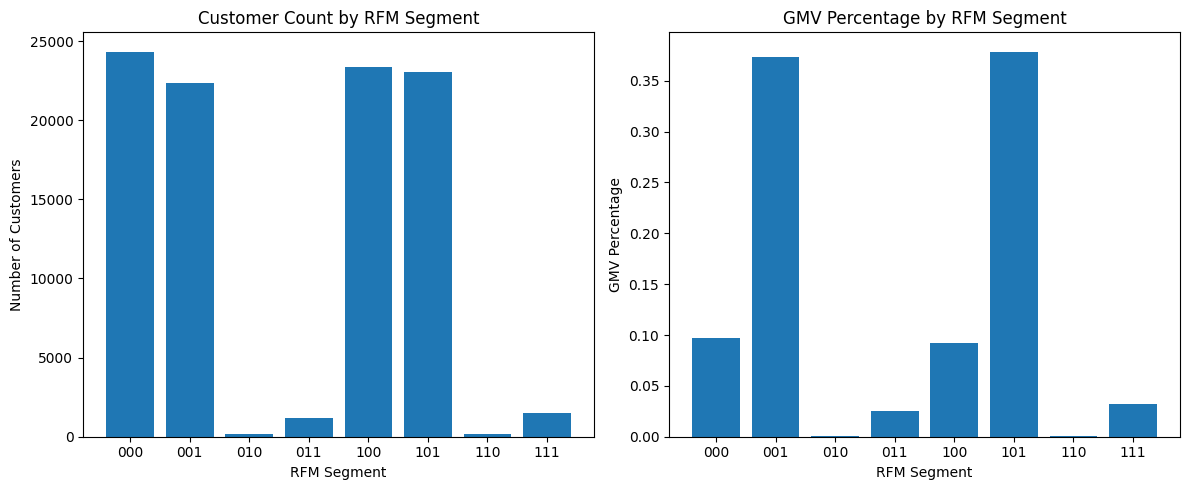

In [15]:
# 可视化各分段人数与GMV占比 / Visualize the number of customers and GMV percentage by segment
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 左图：客户数量 / Left plot: Number of customers
axes[0].bar(segment_stats['RFM_segment'], segment_stats['customer_count'])
axes[0].set_title('Customer Count by RFM Segment')
axes[0].set_xlabel('RFM Segment')
axes[0].set_ylabel('Number of Customers')

# 右图：GMV 占比 / Right plot: GMV percentage
axes[1].bar(segment_stats['RFM_segment'], segment_stats['GMV_pct'])
axes[1].set_title('GMV Percentage by RFM Segment')
axes[1].set_xlabel('RFM Segment')
axes[1].set_ylabel('GMV Percentage')

plt.tight_layout()

根据前述分段统计结果，我们可以得出：

1. **高价值拉新 & 挽留最关键**

   * `101`（重要发展客户）和 `001`（重要挽留客户）共计约 $45400$ 人，贡献了约 $75\%$ 的 GMV，远超其他任何分群。
   
   * **措施聚焦**：

     * 对新高价值（101）群体，迅速执行交叉与补购推荐，增加复购深度。
     * 对高价值流失（001）群体，实施一对一定制化挽留，以防核心收入流失。

2. **大规模普通群体潜力待挖掘**

   * `000` 与 `100` 两类大体量低频低额群体（共约 $47700$ 人）各自仅贡献 $9–10\%$ GMV。
   
   * **措施聚焦**：

     * 普通挽留（000）提供基础唤回激励；
     * 新客发展（100）可通过欢迎礼包等方式提升首次后续转化。

3. **极小群体可整合或重点测试**

   * `010`、`110` 等小规模群体 ($< 200$ 人) 与 `011`、`111` ($< 1500$ 人) 可与相邻群体合并运营，或针对性进行小规模试点，不宜大规模投入资源。
  
---

Based on the segmented statistical results above, we can draw the following conclusions:

1. **High-Value Acquisition & Retention Are Most Critical**

   * The segments `101` (High-Potential New Customers) and `001` (High-Value At-Risk Customers) together include approximately 45,400 users, contributing about $75\%$ of total GMV — far surpassing any other segment.
   * **Strategic Focus**:
     * For high-value new customers (`101`): implement rapid cross-selling and replenishment recommendations to deepen repurchase behavior.
     * For high-value churn-risk customers (`001`): apply personalized, one-on-one retention strategies to prevent the loss of core revenue streams.

2. **Large-Scale Ordinary Segments Have Untapped Potential**

   * Segments `000` and `100`, which represent low-frequency, low-spending user groups (totaling about 47,700 users), each contribute only $9–10\%$ of GMV.
     
   * **Strategic Focus**:
     * * For ordinary inactive users (`000`): provide basic reactivation incentives.
     * For newly acquired but low-engagement users (`100`): consider welcome packages to boost follow-up conversion after their first order.

3. **Very Small Segments Can Be Merged or Tested Selectively**

   * Small-scale segments like `010` and `110` (each with $< 200$ users) and `011`, `111` (< 1,500 users) can either be merged with neighboring segments for broader campaigns or used in targeted pilot tests.
     Large-scale resource investment is not recommended for these groups at this stage.

> **总结**：将有限的营销资源优先投放在高影响力的高价值新客（101）与高价值流失客（001）上，同时对大规模普通群体（000、100）通过标准化优惠进行批量激励，能最大化 GMV 提升与成本效率。

---

> **Summary**:
> Prioritize limited marketing resources on high-impact segments — high-value new customers (`101`) and high-value at-risk customers (`001`).
> At the same time, apply standardized incentives to large ordinary segments (`000`, `100`) to drive bulk engagement.
> This approach maximizes GMV growth while maintaining cost efficiency.

## 4. K-means 聚类实现用户分群 /  K-means Clustering for Customer Segmentation

### 4.1 试 K = 3…8 / Test K = 3…8

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


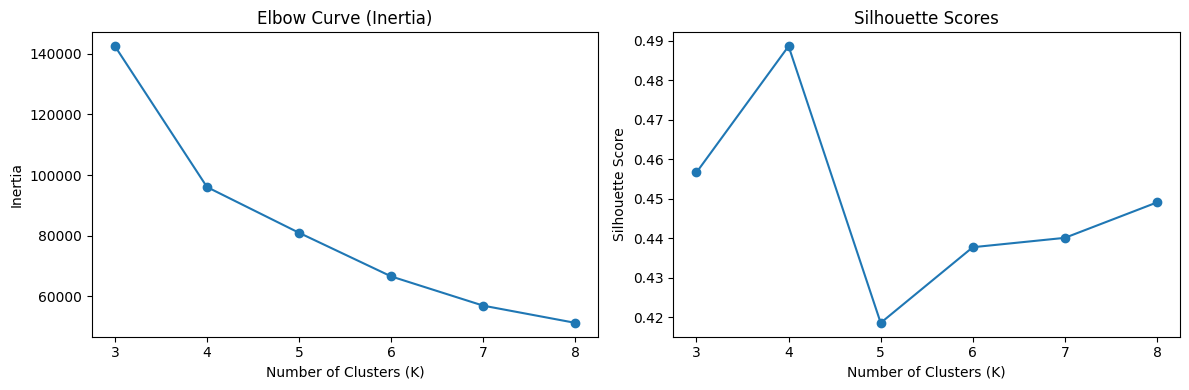

In [16]:
# 取 R_z, F_z, M_z 作为特征 / Use standardized R, F, M
X = rfm[['R_z','F_z','M_z']]

inertia = []
sil_scores = []

for k in range(3, 9):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))


# 可视化 Elbow 曲线 & Silhouette 得分 / Visualize Elbow curve & Silhouette score
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Elbow 曲线 / Elbow Plot
axes[0].plot(range(3,9), inertia, marker='o')
axes[0].set_title('Elbow Curve (Inertia)')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')

# Silhouette 得分 / Silhouette Scores
axes[1].plot(range(3,9), sil_scores, marker='o')
axes[1].set_title('Silhouette Scores')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')

plt.tight_layout()

从 Elbow 曲线和 Silhouette 得分来看，K=4 是最佳选择：

* **Elbow**：从 K=3 到 K=4 的惯性（Inertia）下降最显著，之后下降趋于平缓。
* **Silhouette**：在 K=4 时得分最高，表明此时簇内紧密、簇间分离效果最好。

---

Based on the Elbow curve and Silhouette score, **K=4** is the optimal choice:

* **Elbow**: The drop in inertia from K=3 to K=4 is the most significant, after which the decrease becomes more gradual.
* **Silhouette**: The highest score is achieved at K=4, indicating the best balance of tight intra-cluster cohesion and clear inter-cluster separation.

### 4.2 选定最佳 K 并打簇编号标签 / Select best K and assign cluster labels

In [17]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
rfm['cluster'] = kmeans.fit_predict(X)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


### 4.3 不平衡处理 / Handle Imbalance

In [18]:
# 记录每簇样本量 / Check cluster sizes
cluster_counts = rfm['cluster'].value_counts().sort_index()
print(cluster_counts)

cluster
0    38656
1    52056
2     2962
3     2422
Name: count, dtype: int64


而簇 0 和 1 加起来超过 90%，属于明显的类别不平衡。如果后续要用这个标签做监督学习，直接训练很可能会偏向多数类，导致模型对小簇预测效果不佳。可以通过在监督学习时（如 LightGBM、XGBoost、sklearn 的 GBM）设置 `class_weight='balanced'` 来缓解。

---

Clusters 0 and 1 together account for over 90% of the data, indicating a clear class imbalance. If this clustering label is later used for supervised learning, training directly on the raw labels may lead to the model being biased toward the majority classes, resulting in poor performance on the smaller clusters.

To mitigate this, you can set `class_weight='balanced'` when using supervised learning models such as LightGBM, XGBoost, or sklearn's Gradient Boosting to help the model better handle the imbalance.

### 4.4 簇画像解释 / Cluster Profiling

In [19]:
# 计算每簇的均值 / Compute cluster means for R, F, M
profile = rfm.groupby('cluster')[['R','F','M']].mean().reset_index()

# 如有其他业务补充指标，也可一并计算
# 例如：客单价 = M / F
rfm['order_value'] = rfm['M'] / rfm['F']
profile_ext = rfm.groupby('cluster')[['R','F','M','order_value']].mean().reset_index()
profile_ext

,cluster,R,F,M,order_value
0,0,437.812086,1.000000,134.923163,134.923163
1,1,177.361668,1.000000,135.164795,135.164795
2,2,268.306212,2.116475,290.305945,136.983130
3,3,288.490091,1.015690,1196.225244,1177.718060


**解读**：

* **簇 0**（`cluster=0`）

  * **R≈438 天**：距离最后一次购买非常久，用户已经基本流失
  * **F=1 笔订单**：单次购买用户
  * **M≈135 元**：单次客单价较低
  * **画像**：典型一次性、低客单价且流失的用户
  * **建议**：大规模泛化唤回（如低门槛优惠券）

* **簇 1**（`cluster=1`）

  * **R≈177 天**：半年左右未复购，尚在流失边缘
  * **F=1 笔订单**：依然是单次购买
  * **M≈135 元**：客单价与簇 0 相仿
  * **画像**：新近购买过一次但未复购的低价值新客
  * **建议**：首单后激励（如二次购买优惠券）

* **簇 2**（`cluster=2`）

  * **R≈268 天**：较长时间未复购
  * **F≈2.1 笔订单**：有过多于一次的复购
  * **M≈290 元**：总体消费水平中等
  * **画像**：偶尔复购的中等价值用户
  * **建议**：提升粘性（如套餐/捆绑优惠）

* **簇 3**（`cluster=3`）

  * **R≈288 天**：较久未复购，但并非特别流失
  * **F≈1 笔订单**：主要也是单次交易
  * **M≈1,196 元**：一次性大额消费
  * **画像**：高客单大额一次性购买者
  * **建议**：高端定制关怀（如 VIP 专属推荐、会员服务）

---

**Interpretation**:

* **Cluster 0** (`cluster = 0`)

  * **R ≈ 438 days**: Very long since the last purchase — user is essentially lost
  * **F = 1 order**: One-time buyer
  * **M ≈ ¥135**: Low order value
  * **Profile**: A typical one-time, low-spending, and churned customer
  * **Recommendation**: Broad recall campaigns (e.g., low-barrier coupons)

* **Cluster 1** (`cluster = 1`)

  * **R ≈ 177 days**: No repeat purchase for about half a year — on the verge of churn
  * **F = 1 order**: Still a one-time buyer
  * **M ≈ ¥135**: Similar order value to Cluster 0
  * **Profile**: Recently acquired, low-value customer who hasn't repurchased
  * **Recommendation**: Post-first-purchase incentives (e.g., second-order discount)

* **Cluster 2** (`cluster = 2`)

  * **R ≈ 268 days**: Long time since last purchase
  * **F ≈ 2.1 orders**: Has made repeat purchases
  * **M ≈ ¥290**: Moderate overall spending
  * **Profile**: Occasional repeat buyer with mid-level value
  * **Recommendation**: Increase retention (e.g., bundle deals or combo offers)

* **Cluster 3** (`cluster = 3`)

  * **R ≈ 288 days**: Quite a while since the last purchase, but not fully churned
  * **F ≈ 1 order**: Mostly single transaction
  * **M ≈ ¥1,196**: High-value, one-time purchase
  * **Profile**: Big spender with a one-off, high-ticket transaction
  * **Recommendation**: Premium personalized care (e.g., VIP recommendations, membership services)

## 5. 监督分类器 — 实时打标签 / Supervised Classifier for Real-time Labeling

这里，我们使用 K-means 标签而非 RFM 八段标签来训练，因为：
* **K-means**：4 类且最小簇样本量均在千以上，不至于过度不平衡，模型可稳定学习；
* **RFM 八段**：8 类中少数类样本数 < 200，极度不平衡，难以训练出对少数类有效的模型。

---

Here, we use the K-means labels instead of the 8-segment RFM labels for training, because:

* **K-means**: The 4 clusters each contain over 1,000 samples, avoiding severe class imbalance and allowing the model to learn stably.
* **RFM 8-segment**: Several of the 8 classes have fewer than 200 samples, leading to extreme imbalance and making it difficult to train a model that performs well on the minority classes.

### 5.1 特征集 / Feature Set
* **基础特征 / Basic**: `R, F, M`
* **补充特征 / Supplementary**:

  * 客单价 `order_value`
  * 品类多样度 `category_count`（每客户购买过的不同品类数）
  * 地区 `customer_state`
  * 支付方式 `payment_type`
  * …（其他实时可得特征）

---

* **Basic Features**: `R`, `F`, `M`
* **Supplementary Features**:

  * **Order Value**: `order_value`
  * **Category Diversity**: `category_count` (number of distinct product categories purchased by each customer)
  * **Region**: `customer_state`
  * **Payment Method**: `payment_type`
  * … (other real-time accessible features)

In [20]:
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')

# ——— 1) 计算品类多样度：每客户购买过的不同品类数 / Category diversity per customer ———
oi = order_items[['order_id', 'product_id']]
oi = oi.merge(orders[['order_id', 'customer_id']], on='order_id', how='left')
oi = oi.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
oi = oi.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
category_count = (
    oi
    .groupby('customer_unique_id')['product_category_name']
    .nunique()
    .reset_index(name='category_count')
)

# ——— 2) 提取主要支付方式：每客户出现频次最高的 payment_type / Most common payment type per customer ———
pay = payments[['order_id', 'payment_type']]
pay = pay.merge(orders[['order_id', 'customer_id']], on='order_id', how='left')
pay = pay.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
common_payment = (
    pay
    .groupby('customer_unique_id')['payment_type']
    .agg(lambda x: x.mode()[0])
    .reset_index()
)

# ——— 3) 区域特征：customer_state / Region feature ———
region = customers[['customer_unique_id', 'customer_state']].drop_duplicates()

# ——— 4) 合并所有特征到一个表 / Merge all features ———
features = (
    rfm[['customer_unique_id', 'R', 'F', 'M', 'order_value', 'cluster']]
    .merge(category_count, on='customer_unique_id', how='left')
    .merge(region, on='customer_unique_id', how='left')
    .merge(common_payment, on='customer_unique_id', how='left')
)

# 缺失值处理 / Fill missing category_count with 0
features['category_count'] = features['category_count'].fillna(0)

# ——— 5) 构造 X 和 y / Define X and y ———
X = features[['R', 'F', 'M', 'order_value', 'category_count', 
              'customer_state', 'payment_type']]
y = features['cluster']

# ——— 6) 对类别特征做独热编码 / One-hot encode categorical features ———
X = pd.get_dummies(X, columns=['customer_state', 'payment_type'], drop_first=True)

### 5.2 训练-验证分层切分 / Stratified Train-Validation Split

In [21]:
# 保持各簇比例 / Stratify by y
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### 5.3 模型选择：LightGBM / Model Choice: LightGBM

In [22]:
# 模型参数设置 / Model Params Settings
model = LGBMClassifier(
    objective='multiclass',
    num_class=y.nunique(),
    class_weight='balanced',  # deal with imbalance problems
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_estimators=1000
)

# 模型训练 / Model Training
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='None',  # we will use Macro F1 score from sklearn
    callbacks=[
        early_stopping(50),
        log_evaluation(100)
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 76908, number of used features: 34
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.00547272
Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.00488653


LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=1000,
               num_class=4, objective='multiclass', random_state=42)

### 5.4 评估指标：Macro F1 / Evaluation Metric: Macro F1
> **为何选 Macro F1**：
>
> * 同时关注 Precision（精准率）与 Recall（召回率）；
> * 对每个类别一视同仁，弱化多数类对整体分数的主导作用，适用于不平衡多分类。

---

> **Why choose Macro F1**:
>
> * It considers both Precision and Recall, providing a balanced evaluation of model performance.
> * It treats all classes equally, reducing the dominance of majority classes in the overall score — making it well-suited for imbalanced multiclass classification.

In [23]:
# Macro F1
y_pred = model.predict(X_val)
macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f"Validation Macro F1: {macro_f1:.4f}")

# Classification report
print('Classification report:')
print(classification_report(y_val, y_pred))

Validation Macro F1: 0.9960
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7732
           1       1.00      1.00      1.00     10412
           2       1.00      1.00      1.00       600
           3       0.99      0.99      0.99       484

    accuracy                           1.00     19228
   macro avg       1.00      1.00      1.00     19228
weighted avg       1.00      1.00      1.00     19228



这些结果几乎完美（Macro F1=0.9960），说明模型能非常精准地用给定特征复制 K-means 的分群。

These results are nearly perfect (Macro F1 = 0.9960), indicating that the model can replicate the K-means clustering with high precision using the given features.

### 5.5 解释：特征重要性 & SHAP 摘要 / Interpretation: Feature Importance & SHAP

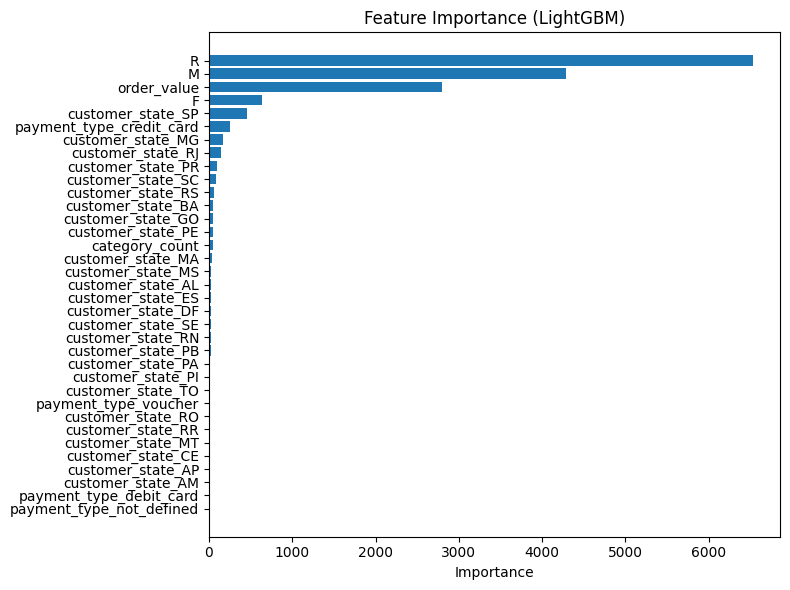

In [24]:
# 1) 特征重要性 / Feature Importance
fi = pd.DataFrame({
    'feature':    model.feature_name_,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# print("Feature Importances:")
# print(fi)

# 可视化 / Visualization 
plt.figure(figsize=(8,6))
plt.barh(fi['feature'], fi['importance'])
plt.title('Feature Importance (LightGBM)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
# plt.bar(fi['feature'], fi['importance'])
# plt.ylabel('Importance')
plt.tight_layout()

In [25]:
print("Feature Importances:")
print(fi)

Feature Importances:
                     feature  importance
0                          R        6529
2                          M        4291
3                order_value        2802
1                          F         635
29         customer_state_SP         452
31  payment_type_credit_card         250
14         customer_state_MG         166
22         customer_state_RJ         139
21         customer_state_PR          92
27         customer_state_SC          86
26         customer_state_RS          59
8          customer_state_BA          48
12         customer_state_GO          48
19         customer_state_PE          46
4             category_count          43
13         customer_state_MA          32
15         customer_state_MS          29
5          customer_state_AL          25
11         customer_state_ES          25
10         customer_state_DF          24
28         customer_state_SE          23
23         customer_state_RN          20
18         customer_state_PB        

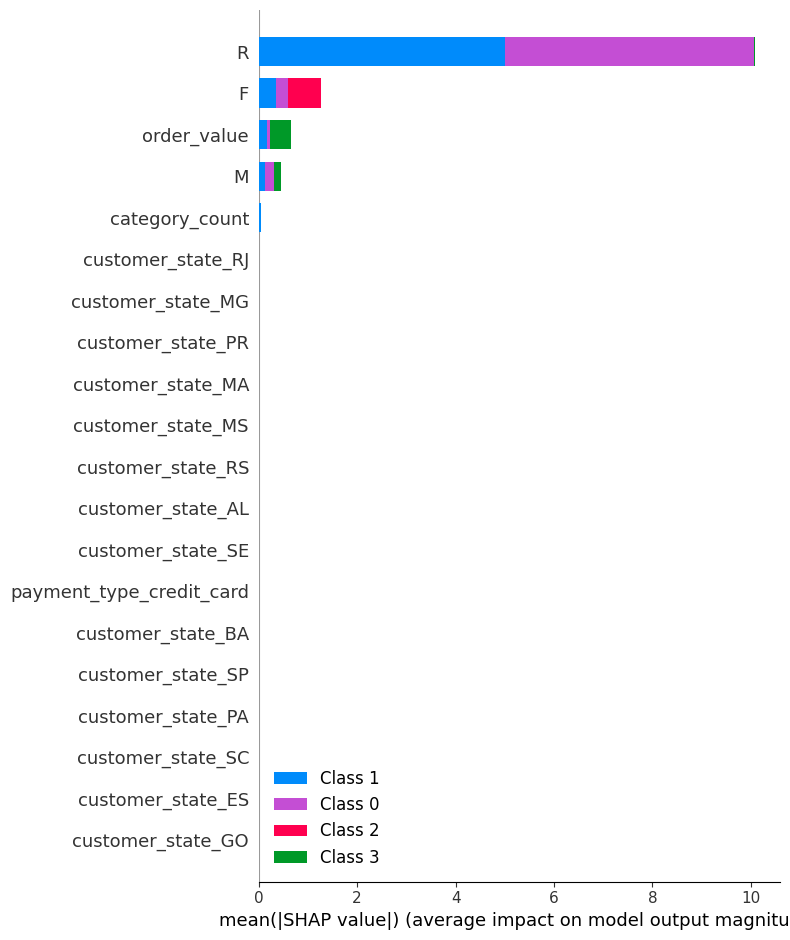

In [26]:
# 2) SHAP 分析 / SHAP Analysis
# 创建解释器 / Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# 计算验证集的 SHAP 值（list of arrays for each class）  
shap_values = explainer.shap_values(X_val)

# 2.1 全局摘要图（条形图）/ SHAP summary bar plot
shap.summary_plot(shap_values, X_val, plot_type='bar')

**综合结论：**

* 从 LightGBM 原生特征重要性和 SHAP 平均绝对值排名来看，最近购买天数（R） 是最关键的分群依据，其次是累计消费金额（M），再其次是平均客单价（order\_value）；购买频次（F） 的作用相对较小；地区（customer\_state） 与支付方式（payment\_type） 几乎不起决定性作用。

**业务建议：**

1. **基于“距离上次购买时间”触发**

   * 设定阈值（如 180 天、365 天），对不同流失阶段客户推送精准激励优惠券或短信，及时唤回。
2. **高价值客户差异化关怀**

   * 对累计消费高、客单价大的用户（簇 3）提供 VIP 专属礼遇、限量折扣或新品优先体验。
3. **提高复购与客单**

   * 对消费次数高但单次金额低的客户（簇 2）推品类捆绑、满减套餐，提升客单深度和复购黏性。
4. **常规群体标准化运营**

   * 对一次性低频低额用户（簇 0/1）进行低成本唤回（基础优惠券、爆款推荐）；
   * 地域与支付方式对策略效果影响有限，可作为次要维度进行辅助分层。

---


**Overall Conclusion**:

* Based on both LightGBM’s native feature importance and SHAP average absolute values, **recency (R)** — the number of days since the last purchase — is the most critical factor for segmentation, followed by **monetary value (M)** and **average order value (`order_value`)**.
  **Frequency (F)** plays a relatively smaller role, while **region (`customer_state`)** and **payment method (`payment_type`)** show minimal impact on clustering outcomes.

**Business Recommendations**:

1. **Trigger Actions Based on "Time Since Last Purchase"**

   * Define recency thresholds (e.g., 180 days, 365 days) and push targeted incentives (coupons, SMS messages) to customers at different churn risk stages for timely reactivation.

2. **Differentiated Care for High-Value Customers**

   * For customers with high total spend and large order values (e.g., Cluster 3), offer exclusive VIP benefits, limited-time discounts, or early access to new products.

3. **Boost Repurchase Rates and Order Value**

   * For customers with high purchase frequency but low order amounts (e.g., Cluster 2), promote category bundles or threshold-based discounts to increase order depth and repurchase stickiness.

4. **Standardized Operations for Regular Segments**

   * For one-time, low-frequency, low-spend users (e.g., Clusters 0/1), apply low-cost reactivation tactics like basic coupons or best-seller recommendations.
   * Since region and payment method have limited influence on behavior, they can be treated as secondary segmentation dimensions for refinement rather than primary drivers.

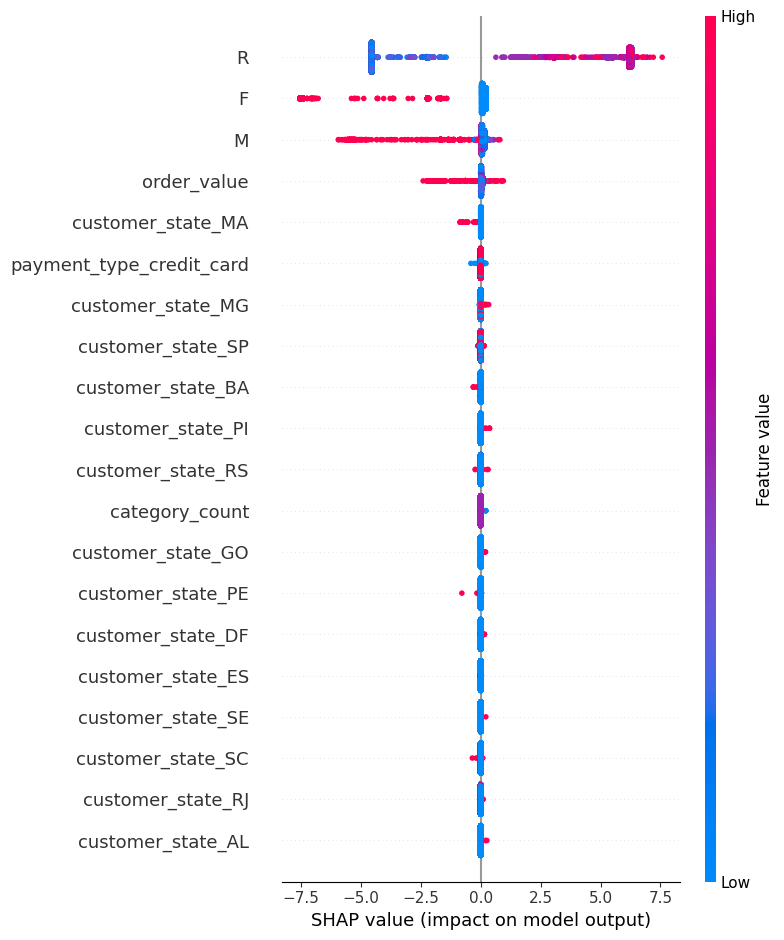

In [27]:
# 2.2 全局摘要图（点图）/ SHAP summary dot plot
# 2.2.1 cluster 0
i = 0
shap.summary_plot(
    shap_values[i],  # 第 i 类的 SHAP 值 / SHAP value of i-th cluster
    X_val,
    show=False,
    title=f"SHAP Summary for Class {i}"
)

**Cluster 0**:

* **核心驱动因素**：近期度 (`R`)、累计消费 (`M`) 和平均客单价 (`order_value`) 是划入 Cluster 0 的最主要判断依据；
* **频次 (`F`)** 起到次要的微调作用；
* **地域和支付方式** 基本不影响该簇的预测。

上述解读可帮助运营团队聚焦：要识别并触达 Cluster 0（高活跃/高价值人群），重点看「最近购买时间」和「消费金额／客单价」即可。

---

**Cluster 0**:

* **Core Drivers**: Recency (`R`), Total Spending (`M`), and Average Order Value (`order_value`) are the primary factors influencing assignment to Cluster 0.
* **Frequency (`F`)** plays a secondary, fine-tuning role.
* **Geographic location and payment method** have little to no impact on predictions for this cluster.

This insight helps the operations team focus their efforts: to identify and engage Cluster 0 (highly active/high-value users), prioritize recent purchase behavior and spending level/order value.

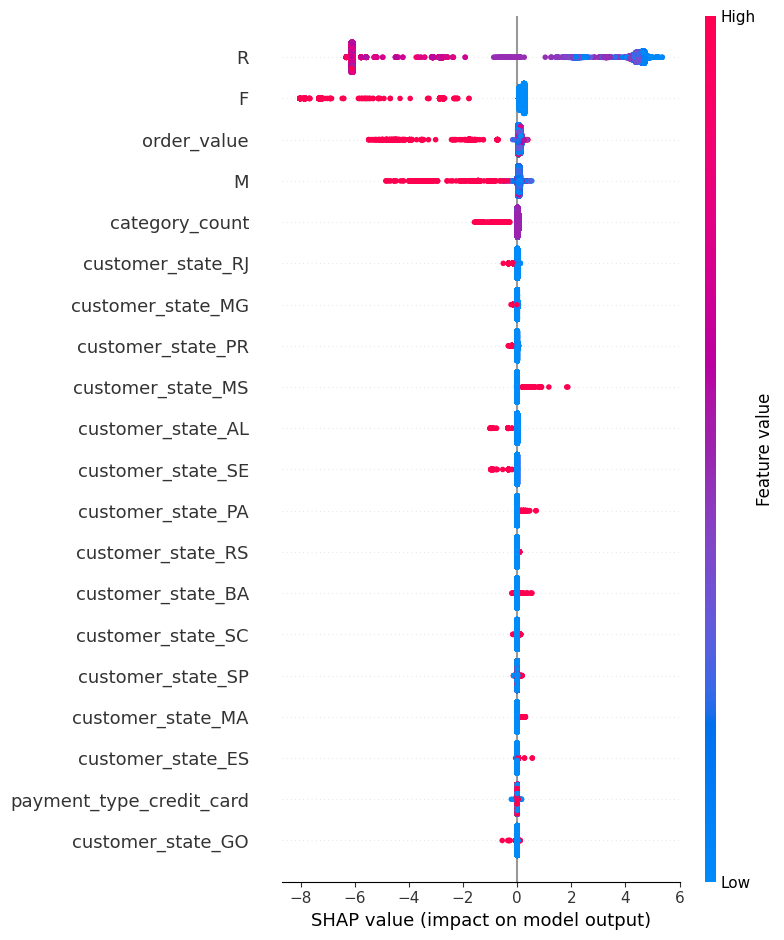

In [28]:
# 2.2.2 cluster 1
i = 1
shap.summary_plot(
    shap_values[i],  # 第 i 类的 SHAP 值 / SHAP value of i-th cluster
    X_val,
    show=False,
    title=f"SHAP Summary for Class {i}"
)

**Cluster 1** 即“**久未复购、低频、低价、低价值**”的客户群，模型主要依赖 **Recency (`R`)** 做出区隔，其次依次是 **Frequency (`F`)**、**Monetary (`M`)** 和 **Average Order Value (`order_value`)**，地理与支付方式几乎不影响。

---

**Cluster 1** represents the "**inactive, low-frequency, low-value**" customer group. The model primarily relies on **Recency (`R`)** for differentiation, followed by **Frequency (`F`)**, **Monetary (`M`)**, and **Average Order Value (`order_value`)**. Geographic location and payment method have minimal impact on this cluster’s segmentation.

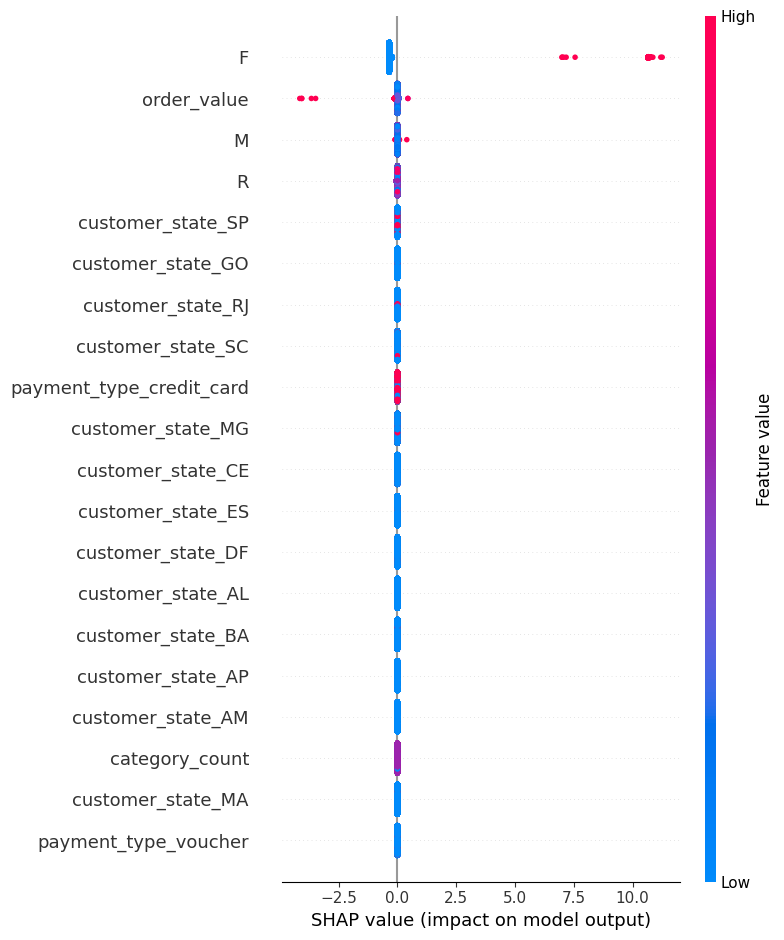

In [29]:
# 2.2.3 cluster 2
i = 2
shap.summary_plot(
    shap_values[i],  # 第 i 类的 SHAP 值 / SHAP value of i-th cluster
    X_val,
    show=False,
    title=f"SHAP Summary for Class {i}"
)

**Cluster 2**（偶尔复购的中等价值用户）的主要判别信号是 **高购买频次**、**低客单价** 和 **低累计消费**，其次参考 **近期购买** 情况；地域与支付方式几乎不影响该簇的划分。基于此，运营可针对这类用户重点做“捆绑/套餐提升客单”与“购买频次奖励”策略。

---

For **Cluster 2** (occasional repeat purchasers with medium value), the key distinguishing signals are **high purchase frequency**, **low average order value**, and **low total spending**, with **recent purchase activity** as a secondary reference. Geographic location and payment method have little impact on this cluster’s segmentation.

Based on these insights, operations can focus on strategies such as **bundling/packages to increase order value** and **frequency-based purchase incentives** for this user group.

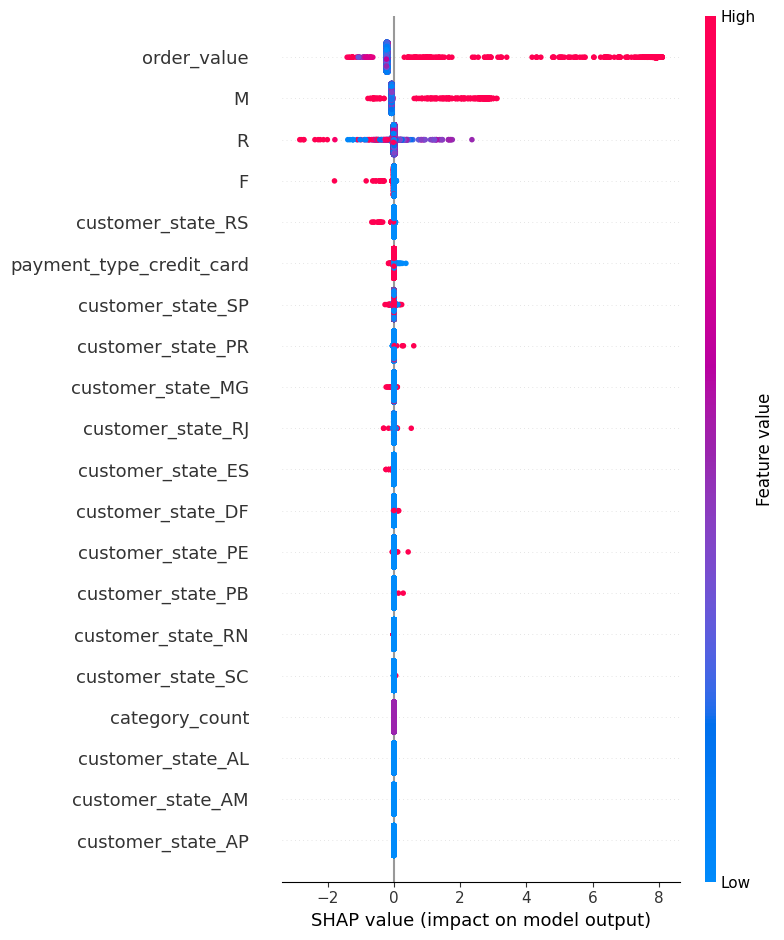

In [30]:
# 2.2.4 cluster 3
i = 3
shap.summary_plot(
    shap_values[i],  # 第 i 类的 SHAP 值 / SHAP value of i-th cluster
    X_val,
    show=False,
    title=f"SHAP Summary for Class {i}"
)

**Cluster 3**：
* **首要驱动**：平均客单价（`order_value`）> 累计消费（`M`）
* **次要微调**：购买频次（`F`）略有作用，Recency（`R`）影响不显著
* **可忽略**：品类多样度、地域、支付方式

这与业务标签“高客单一次性高价值用户”高度吻合——要识别这类人，重点看他们的“客单价”和“总消费”即可。

---

**Cluster 3**:
* **Primary Driver**: Average order value (`order_value`) > Total monetary value (`M`)
* **Secondary Adjustment**: Purchase frequency (`F`) plays a minor role; recency (`R`) has little impact
* **Negligible Factors**: Product category diversity, geographic location, and payment method

This aligns closely with the business label of "high-order-value, one-time high-value users" — to identify this group, the key is to focus on their **average order value** and **total spending**.